# Desafio de Programação Final

## Identificação:

**Nome: Daniel Toledo Dantas**

**Matrícula: 211068477**

## 1. Preparação do Ambiente

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import sys

import numpy as np

import matplotlib.pyplot as plt

from scipy import optimize

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import math
from scipy.special import erfc

from pylab import *
from sklearn.manifold import TSNE

In [3]:
sys.path.append('/content/drive/MyDrive/TopEng/DPF') # alterar diretorio possivelmente
import utils_exp2

In [4]:
train_on_gpu = torch.cuda.is_available() #Check if the GPU is available
if train_on_gpu: #if yes
    device = torch.device('cuda') #Select device as GPU
    print("Treinando na GPU.")
else: #Se não
    device = torch.device('cpu') #Select device as CPU
    print("GPU indisponível, treinando na CPU.")

GPU indisponível, treinando na CPU.


## 2. Arquitetura da rede

In [5]:
class autoencoder(nn.Module):
    def __init__(self,messages,n_net):
        super(autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(messages,n_net),
            nn.ReLU(True),
            nn.Linear(n_net,n_net),
            nn.BatchNorm1d(n_net, affine=True))

        self.decoder = nn.Sequential(
            nn.Linear(n_net,n_net),
            nn.ReLU(True),
            nn.Linear(n_net,messages),
            nn.Softmax(dim=-1))

    def forward(self, data, bit_rate, n_net, signal_noise):
        outs = {}
        data_size = data.shape[0]
        # codificando
        data = self.encoder(data)

        # Normalização
        data = nn.functional.normalize(data, p=2, dim=-1)
        data = data*(math.sqrt(n_net/2))

        outs['encoded'] = data

        # Adicionando ruido
        noise_channel = torch.normal(0.0, math.sqrt(1/(2*bit_rate*(10.0**(signal_noise/10.0)))),[data_size, n_net])
        data = data + noise_channel

        outs['encoded_noise'] = data

        # decodificando
        data = self.decoder(data)

        outs['decoded'] = data

        return outs

    def auto_encoder(self, data, n_channel):
        data = self.encoder(data)
        data = nn.functional.normalize(data, p=2, dim=-1)
        data = data*(n_channel/math.sqrt(n_channel))
        return data

    def auto_decoder(self, data):
        data = self.decoder(data)
        return data

## 3. Função de treinamento

In [50]:
def qamTrain(channel_uses,bits,num_epochs):
  model,batch_size,data,criterion,optimizer,bit_rate,n_net,signal_noise = TrainParams(channel_uses,bits)

  loss_epoch = []

  for epoch in range(num_epochs):
      # Definição do dataset (aleatório para cada época)
      dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

      # Para cada batch size em 'dataloader'
      for input_in in dataloader:
          # ===================forward=====================
          # Codificação do sinal de entrada
          output = model(input_in,bit_rate,n_net,signal_noise)
          # Formatação dos dados para comparação na função de custo
          target_crossEntropy = torch.argmax(input_in, dim=-1).type(torch.LongTensor)
          # Cross-Entropy Loss
          loss = criterion(output['decoded'], target_crossEntropy)
          # ===================backward====================
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      loss_epoch.append(loss.data)
      print('QAM - epoch [{}/{}], loss:{:.4f}'
            .format(epoch + 1, num_epochs, loss.data))

  return model,loss_epoch

In [31]:
def pskTrain(channel_uses,bits,num_epochs):
  model,batch_size,data,criterion,optimizer,bit_rate,n_net,signal_noise = TrainParams(channel_uses,bits)

  loss_epoch = []

  for epoch in range(num_epochs):
      # Definição do dataset (aleatório para cada época)
      dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

      # Para cada batch size em 'dataloader'
      for input_in in dataloader:
          # ===================forward=====================
          # Codificação do sinal de entrada
          output = model(input_in,bit_rate,n_net,signal_noise)
          # Formatação dos dados para comparação na função de custo
          target_crossEntropy = torch.argmax(input_in, dim=1).type(torch.LongTensor)
          # Cross-Entropy Loss
          loss = criterion(output['decoded'], target_crossEntropy)
          # ===================backward====================
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      loss_epoch.append(loss.data)
      print('PSK - epoch [{}/{}], loss:{:.4f}'
            .format(epoch + 1, num_epochs, loss.data))

  return model,loss_epoch

## 4. Funções de Plotagem

In [8]:
def lossCurve(loss_epoch,channel_uses,bits):
  # Plot da curva de Loss
  vector_loss = np.arange(0,len(loss_epoch),1)
  fig = plt.figure(figsize=(10,8))
  plt.plot(vector_loss,loss_epoch,'b',label='Autoencoder(%d,%d)'%(channel_uses, bits))
  plt.xlabel('Epoca')
  plt.ylabel('Loss')
  plt.title('Loss por Época')
  plt.legend(loc='lower left',ncol = 1)
  plt.grid()
  plt.show()

## 5. Função de teste SER

In [91]:
def SERtest(model,channel_uses,bits,codificacao):
  messages = 2**bits
  signal_noise = 7 # relacao sinal ruido
  n_symbols = 2 # numeros complexos
  n_net = n_symbols*channel_uses

  # Paramêtros de Teste
  N_teste = 100000*messages
  test_label = torch.randint(0, messages, (N_teste,))
  test_data = torch.nn.functional.one_hot(test_label).float()

  # Variáveis de teste
  EbNodB_range = torch.arange(0,8,0.5)
  ber = [None]*len(EbNodB_range)

  # Teste do modelo treinado e cálculo da BER
  for n in range(0,len(EbNodB_range)):
      EbNo=10.0**(EbNodB_range[n]/10.0)
      noise_std = np.sqrt(1/(2*signal_noise*EbNo)).item()
      noise_mean = 0.0
      no_errors = 0
      noise = torch.normal(noise_mean, noise_std,[N_teste, n_net])

      # Embaralhamneto do dataset de teste
      data = TensorDataset(test_data, torch.LongTensor(test_label))
      dataloader_test = DataLoader(data, batch_size=N_teste, shuffle=True)

      # Dividindo o dataset em labels e dados
      test_data_ = dataloader_test.dataset.tensors[0]
      label_ = np.array(dataloader_test.dataset.tensors[1])

      # Codificação do sinal
      encoded_signal = model.auto_encoder(test_data_, n_net/2)

      # Influencia do Canal
      channel_signal = encoded_signal + noise

      # Decodificação do sinal
      pred_final_signal = model.auto_decoder(channel_signal)
      parse_pred_output = pred_final_signal.tolist()
      pred_output = np.argmax(parse_pred_output,axis=1)   #retorna um array com a posição de maior argumento

      # Calculo da BER
      no_errors = (pred_output != label_)
      no_errors =  no_errors.astype(int).sum()
      ber[n] = no_errors / N_teste
      print ('SNR:',EbNodB_range[n].item(),'BLER:',ber[n], 'no_errors:',no_errors)

  ask_M, psk_M, qam_M = utils_exp2.genareteBER(2**bits, EbNodB_range)

  fig = plt.figure(figsize=(10,8))
  fig_title = "Curvas de BLER para Autoencoder("+str(channel_uses)+","+str(bits)+")"
  # pegando caso correspondente
  if codificacao == 'qam':
    plt.plot(EbNodB_range, qam_M, 'ko',label='Teorico')
  else:
    plt.plot(EbNodB_range, psk_M, 'ko',label='Teorico')

  plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder(%d,%d)'%(channel_uses, bits))
  plt.yscale('log')
  plt.xlabel('SNR Range')
  plt.ylabel('BLER')
  plt.title(fig_title)
  plt.grid()
  plt.legend(loc='lower left',ncol = 1)
  plt.show()
  #plt.savefig(fig_name)

## 6. Função de resultado do espaço vetorial

In [80]:
def vectorialSpace(model,channel_uses,bits):
  messages = 2**bits
  # Mensagens codigicadas pelo Encoder
  data_encoded_symbol = model.auto_encoder(torch.eye(messages),channel_uses)

  # Separação dos símbolos em real e imaginário
  real_symb, imag_symb = utils_exp2.split_symb(data_encoded_symbol)

  # Plotagem das constelações por uso do canal
  utils_exp2.plot_graphs(real_symb.detach().numpy(),imag_symb.detach().numpy(),channel_uses,sizefig=5)

## 7. Função de parâmetros de treinamento

In [48]:
def TrainParams(channel_uses,bits,learning_rate=0.001):
  # bits - bits da mensagem
  # channel_uses - usos do canal
  # learning_rate - taxa de aprendizado

  # Rede
  messages = 2**bits # total de mensagens possiveis
  bit_rate = bits/channel_uses # taxa de transmissao de bits

  # Relacoes
  signal_noise = 7 # relacao sinal ruido
  n_symbols = 2 # numeros complexos
  n_net = n_symbols*channel_uses # quantos simbolos por uso

  # Treinamento
  batch_size = 10*messages # conj de cada treinamento
  sample_size = batch_size*10 # total de amostras

  # Criando amostras
  train_dataset = torch.eye(messages)
  data = train_dataset.repeat(int(sample_size/messages),1)

  model = autoencoder(messages,n_net)

  # Funcoes da rede
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

  return model,batch_size,data,criterion,optimizer,bit_rate,n_net,signal_noise

# Treinando redes e mostrando resultados

## a) n = 1, k = 2 com modulação PSK

PSK - epoch [1/1000], loss:1.3766
PSK - epoch [2/1000], loss:1.3721
PSK - epoch [3/1000], loss:1.3670
PSK - epoch [4/1000], loss:1.3566
PSK - epoch [5/1000], loss:1.3692
PSK - epoch [6/1000], loss:1.3632
PSK - epoch [7/1000], loss:1.3605
PSK - epoch [8/1000], loss:1.3685
PSK - epoch [9/1000], loss:1.3548
PSK - epoch [10/1000], loss:1.3433
PSK - epoch [11/1000], loss:1.3438
PSK - epoch [12/1000], loss:1.3753
PSK - epoch [13/1000], loss:1.3431
PSK - epoch [14/1000], loss:1.3351
PSK - epoch [15/1000], loss:1.3315
PSK - epoch [16/1000], loss:1.3523
PSK - epoch [17/1000], loss:1.3350
PSK - epoch [18/1000], loss:1.3417
PSK - epoch [19/1000], loss:1.3441
PSK - epoch [20/1000], loss:1.3427
PSK - epoch [21/1000], loss:1.3244
PSK - epoch [22/1000], loss:1.3381
PSK - epoch [23/1000], loss:1.3214
PSK - epoch [24/1000], loss:1.3275
PSK - epoch [25/1000], loss:1.3273
PSK - epoch [26/1000], loss:1.3158
PSK - epoch [27/1000], loss:1.2879
PSK - epoch [28/1000], loss:1.3061
PSK - epoch [29/1000], loss:1

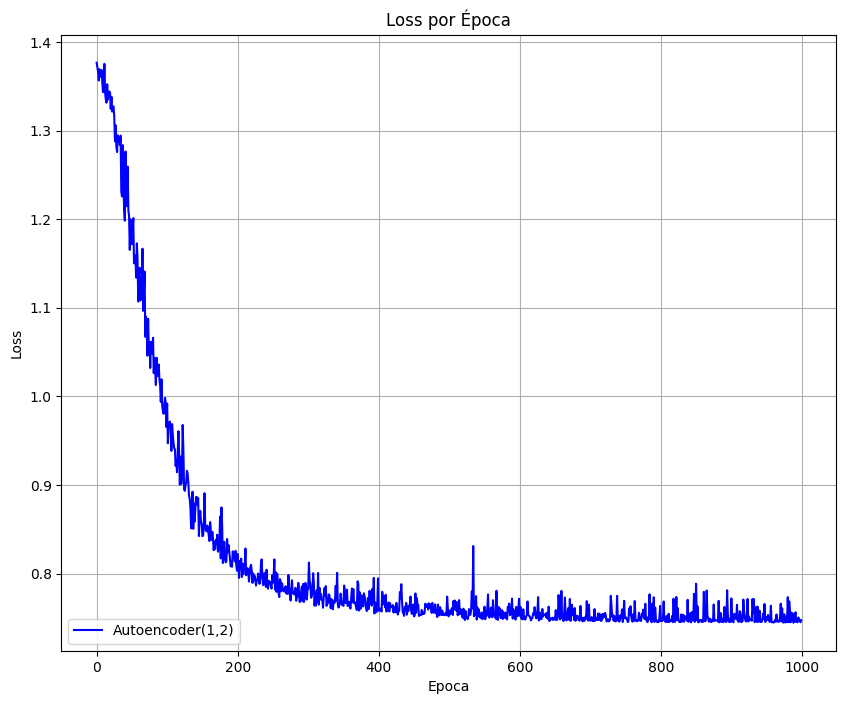

SNR: 0.0 BLER: 0.008995 no_errors: 3598
SNR: 0.5 BLER: 0.0056525 no_errors: 2261
SNR: 1.0 BLER: 0.0032725 no_errors: 1309
SNR: 1.5 BLER: 0.0019875 no_errors: 795
SNR: 2.0 BLER: 0.0010525 no_errors: 421
SNR: 2.5 BLER: 0.000515 no_errors: 206
SNR: 3.0 BLER: 0.0002325 no_errors: 93
SNR: 3.5 BLER: 8.25e-05 no_errors: 33
SNR: 4.0 BLER: 3.75e-05 no_errors: 15
SNR: 4.5 BLER: 1.25e-05 no_errors: 5
SNR: 5.0 BLER: 0.0 no_errors: 0
SNR: 5.5 BLER: 0.0 no_errors: 0
SNR: 6.0 BLER: 0.0 no_errors: 0
SNR: 6.5 BLER: 0.0 no_errors: 0
SNR: 7.0 BLER: 0.0 no_errors: 0
SNR: 7.5 BLER: 0.0 no_errors: 0


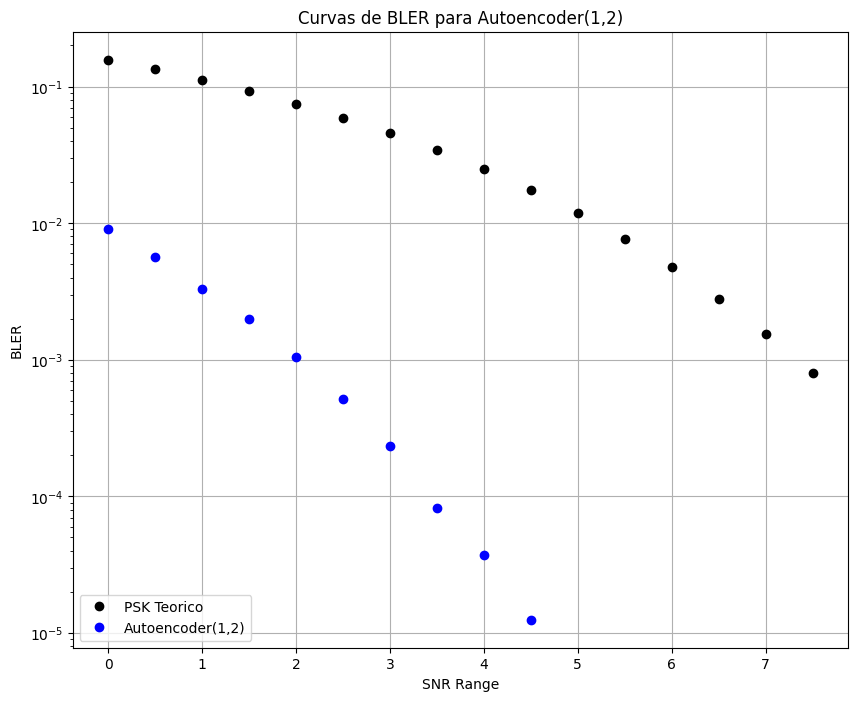

<Figure size 640x480 with 0 Axes>

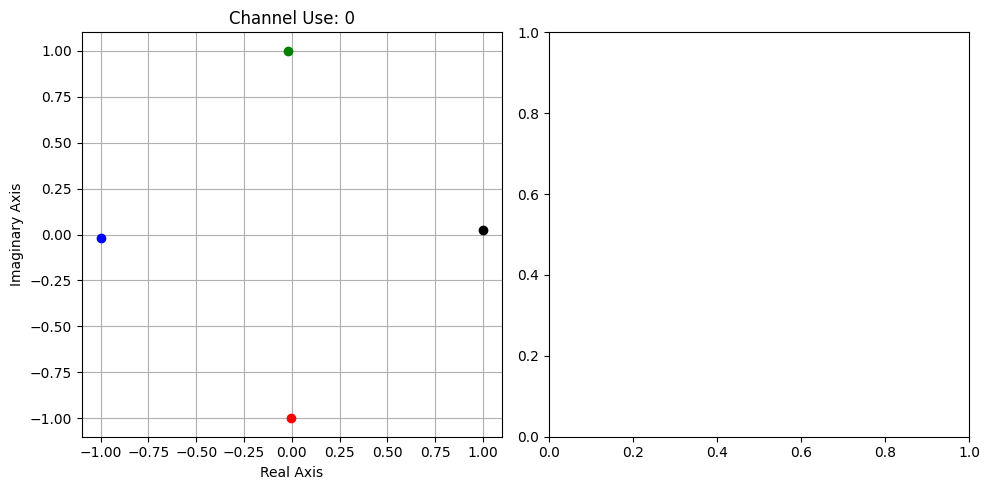

In [86]:
psk,loss_epoch_psk = pskTrain(1,2,1000)
lossCurve(loss_epoch_psk,1,2)
SERtest(psk,1,2,'psk')
vectorialSpace(psk,1,2)

## b) n = 2, k = 2 com modulação PSK

PSK - epoch [1/500], loss:1.4069
PSK - epoch [2/500], loss:1.3883
PSK - epoch [3/500], loss:1.4038
PSK - epoch [4/500], loss:1.3837
PSK - epoch [5/500], loss:1.3882
PSK - epoch [6/500], loss:1.3981
PSK - epoch [7/500], loss:1.3596
PSK - epoch [8/500], loss:1.3980
PSK - epoch [9/500], loss:1.3475
PSK - epoch [10/500], loss:1.3699
PSK - epoch [11/500], loss:1.3820
PSK - epoch [12/500], loss:1.3642
PSK - epoch [13/500], loss:1.3250
PSK - epoch [14/500], loss:1.3639
PSK - epoch [15/500], loss:1.3123
PSK - epoch [16/500], loss:1.3823
PSK - epoch [17/500], loss:1.3743
PSK - epoch [18/500], loss:1.3162
PSK - epoch [19/500], loss:1.3605
PSK - epoch [20/500], loss:1.3235
PSK - epoch [21/500], loss:1.3275
PSK - epoch [22/500], loss:1.3249
PSK - epoch [23/500], loss:1.3730
PSK - epoch [24/500], loss:1.2413
PSK - epoch [25/500], loss:1.2914
PSK - epoch [26/500], loss:1.2686
PSK - epoch [27/500], loss:1.2683
PSK - epoch [28/500], loss:1.2727
PSK - epoch [29/500], loss:1.2662
PSK - epoch [30/500], l

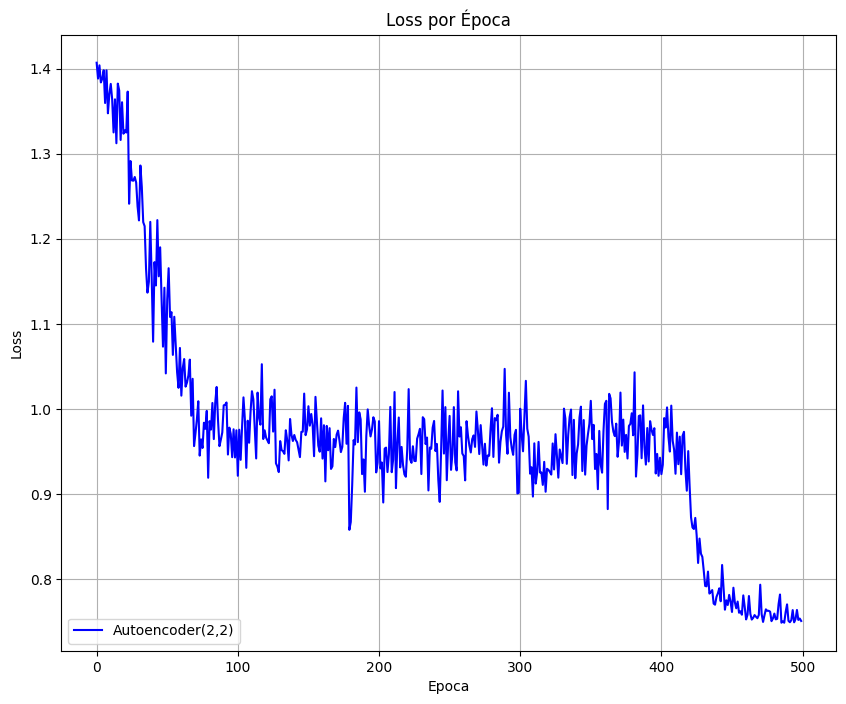

SNR: 0.0 BLER: 0.000325 no_errors: 130
SNR: 0.5 BLER: 0.0001375 no_errors: 55
SNR: 1.0 BLER: 3.25e-05 no_errors: 13
SNR: 1.5 BLER: 1e-05 no_errors: 4
SNR: 2.0 BLER: 5e-06 no_errors: 2
SNR: 2.5 BLER: 0.0 no_errors: 0
SNR: 3.0 BLER: 2.5e-06 no_errors: 1
SNR: 3.5 BLER: 0.0 no_errors: 0
SNR: 4.0 BLER: 0.0 no_errors: 0
SNR: 4.5 BLER: 0.0 no_errors: 0
SNR: 5.0 BLER: 0.0 no_errors: 0
SNR: 5.5 BLER: 0.0 no_errors: 0
SNR: 6.0 BLER: 0.0 no_errors: 0
SNR: 6.5 BLER: 0.0 no_errors: 0
SNR: 7.0 BLER: 0.0 no_errors: 0
SNR: 7.5 BLER: 0.0 no_errors: 0


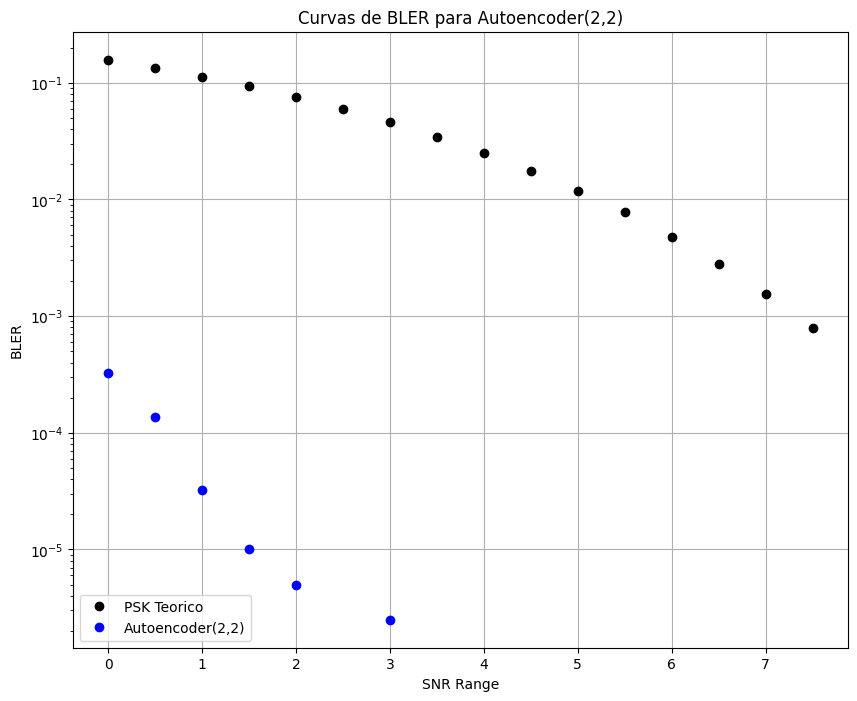

<Figure size 640x480 with 0 Axes>

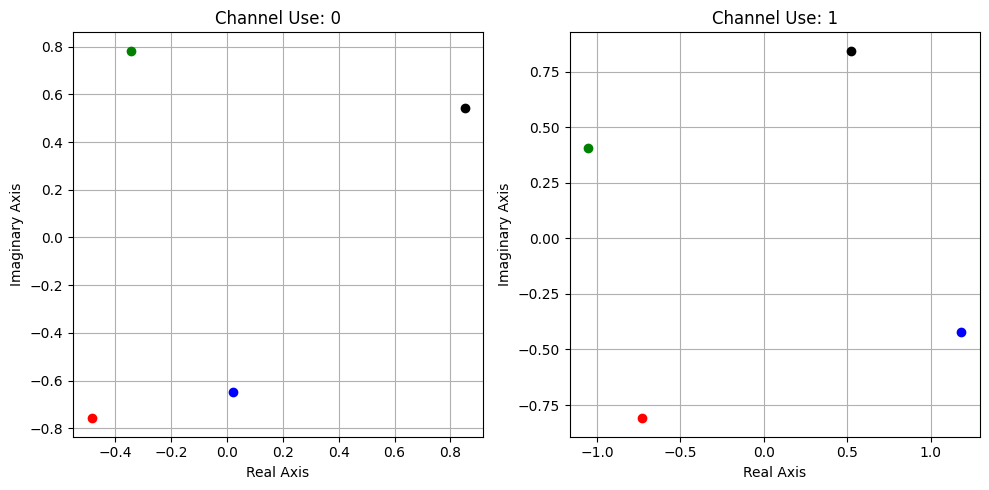

In [87]:
psk,loss_epoch_psk = pskTrain(2,2,500)
lossCurve(loss_epoch_psk,2,2)
SERtest(psk,2,2,'psk')
vectorialSpace(psk,2,2)

## c) n = 3, k = 2 com modulação QAM

QAM - epoch [1/500], loss:1.3651
QAM - epoch [2/500], loss:1.3769
QAM - epoch [3/500], loss:1.3738
QAM - epoch [4/500], loss:1.3440
QAM - epoch [5/500], loss:1.3373
QAM - epoch [6/500], loss:1.3309
QAM - epoch [7/500], loss:1.3370
QAM - epoch [8/500], loss:1.3013
QAM - epoch [9/500], loss:1.3001
QAM - epoch [10/500], loss:1.2896
QAM - epoch [11/500], loss:1.2992
QAM - epoch [12/500], loss:1.2285
QAM - epoch [13/500], loss:1.2646
QAM - epoch [14/500], loss:1.2594
QAM - epoch [15/500], loss:1.2158
QAM - epoch [16/500], loss:1.2369
QAM - epoch [17/500], loss:1.2122
QAM - epoch [18/500], loss:1.2143
QAM - epoch [19/500], loss:1.1600
QAM - epoch [20/500], loss:1.1315
QAM - epoch [21/500], loss:1.1710
QAM - epoch [22/500], loss:1.1641
QAM - epoch [23/500], loss:1.0877
QAM - epoch [24/500], loss:1.1457
QAM - epoch [25/500], loss:1.1734
QAM - epoch [26/500], loss:1.1284
QAM - epoch [27/500], loss:1.0712
QAM - epoch [28/500], loss:1.0934
QAM - epoch [29/500], loss:1.0363
QAM - epoch [30/500], l

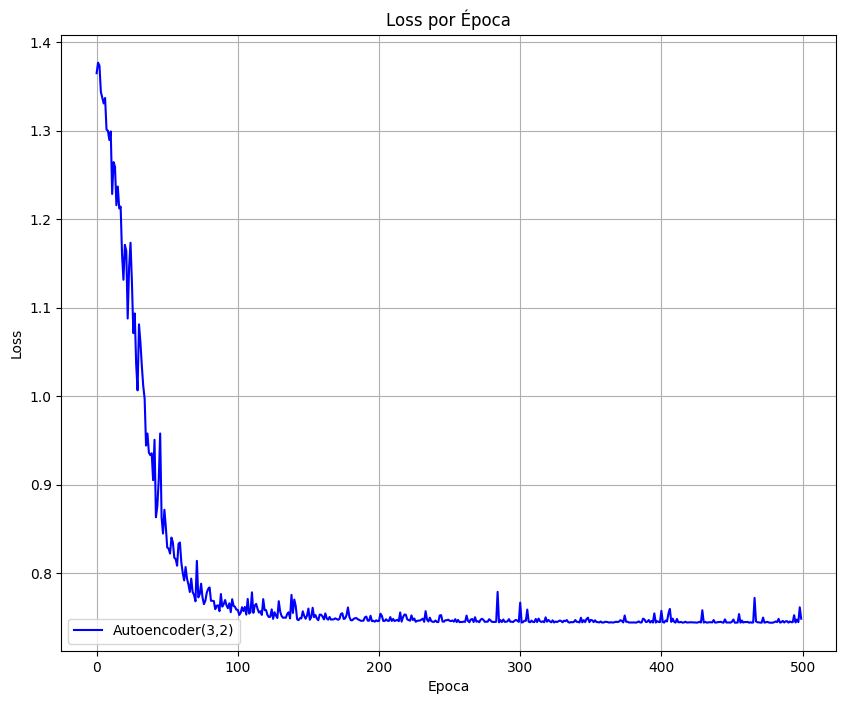

SNR: 0.0 BLER: 0.0 no_errors: 0
SNR: 0.5 BLER: 0.0 no_errors: 0
SNR: 1.0 BLER: 0.0 no_errors: 0
SNR: 1.5 BLER: 0.0 no_errors: 0
SNR: 2.0 BLER: 0.0 no_errors: 0
SNR: 2.5 BLER: 0.0 no_errors: 0
SNR: 3.0 BLER: 0.0 no_errors: 0
SNR: 3.5 BLER: 0.0 no_errors: 0
SNR: 4.0 BLER: 0.0 no_errors: 0
SNR: 4.5 BLER: 0.0 no_errors: 0
SNR: 5.0 BLER: 0.0 no_errors: 0
SNR: 5.5 BLER: 0.0 no_errors: 0
SNR: 6.0 BLER: 0.0 no_errors: 0
SNR: 6.5 BLER: 0.0 no_errors: 0
SNR: 7.0 BLER: 0.0 no_errors: 0
SNR: 7.5 BLER: 0.0 no_errors: 0


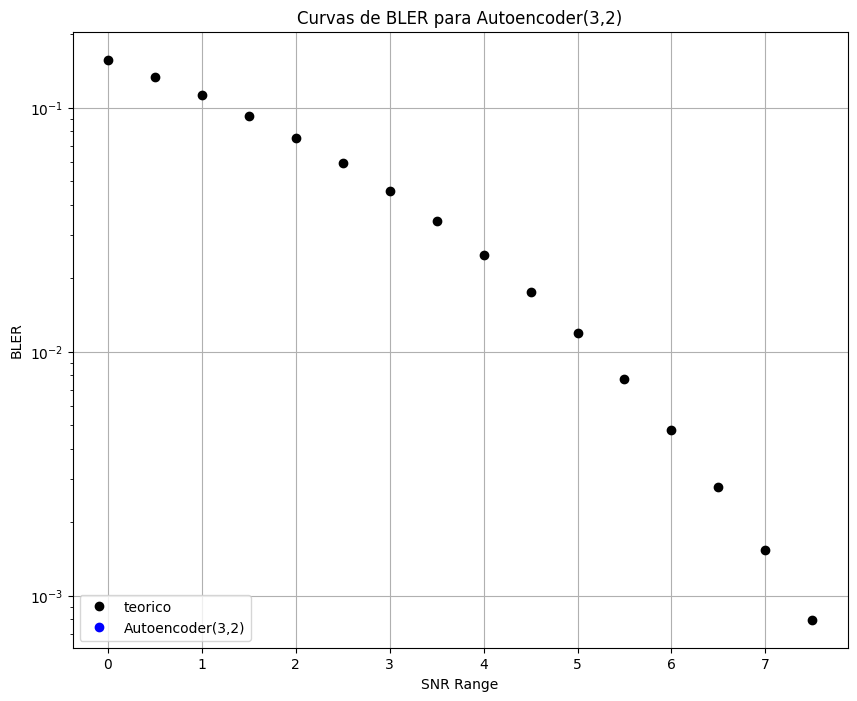

<Figure size 640x480 with 0 Axes>

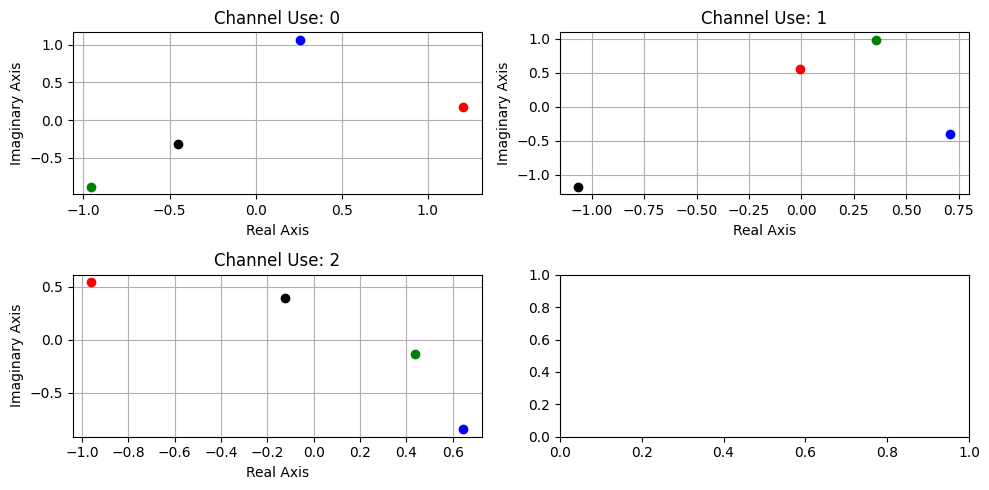

In [88]:
qam,loss_epoch_qam = qamTrain(3,2,500)
lossCurve(loss_epoch_qam,3,2)
SERtest(qam,3,2,'qam')
vectorialSpace(qam,3,2)

## d) n = 2, k = 3 com modulação PSK

PSK - epoch [1/1000], loss:2.0717
PSK - epoch [2/1000], loss:2.0723
PSK - epoch [3/1000], loss:2.0633
PSK - epoch [4/1000], loss:2.0583
PSK - epoch [5/1000], loss:2.0685
PSK - epoch [6/1000], loss:2.0543
PSK - epoch [7/1000], loss:2.0554
PSK - epoch [8/1000], loss:2.0534
PSK - epoch [9/1000], loss:2.0448
PSK - epoch [10/1000], loss:2.0409
PSK - epoch [11/1000], loss:2.0296
PSK - epoch [12/1000], loss:2.0217
PSK - epoch [13/1000], loss:2.0380
PSK - epoch [14/1000], loss:2.0093
PSK - epoch [15/1000], loss:2.0205
PSK - epoch [16/1000], loss:1.9897
PSK - epoch [17/1000], loss:1.9847
PSK - epoch [18/1000], loss:1.9682
PSK - epoch [19/1000], loss:1.9691
PSK - epoch [20/1000], loss:1.9901
PSK - epoch [21/1000], loss:1.9498
PSK - epoch [22/1000], loss:1.9492
PSK - epoch [23/1000], loss:1.9342
PSK - epoch [24/1000], loss:1.9387
PSK - epoch [25/1000], loss:1.9611
PSK - epoch [26/1000], loss:1.9235
PSK - epoch [27/1000], loss:1.9365
PSK - epoch [28/1000], loss:1.9283
PSK - epoch [29/1000], loss:1

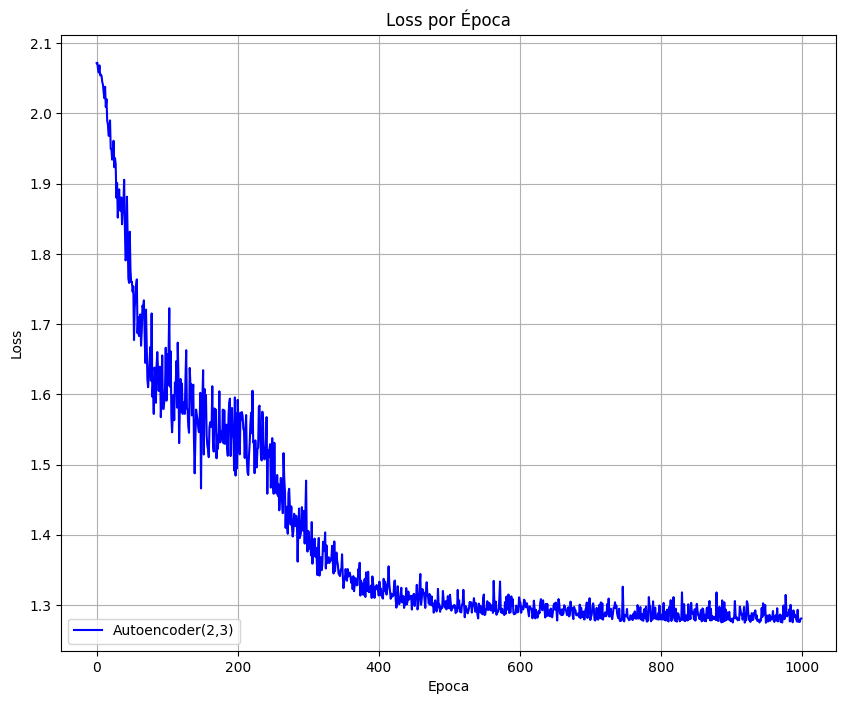

SNR: 0.0 BLER: 0.0049575 no_errors: 3966
SNR: 0.5 BLER: 0.00279125 no_errors: 2233
SNR: 1.0 BLER: 0.00165 no_errors: 1320
SNR: 1.5 BLER: 0.0007575 no_errors: 606
SNR: 2.0 BLER: 0.0003775 no_errors: 302
SNR: 2.5 BLER: 0.00016 no_errors: 128
SNR: 3.0 BLER: 5.875e-05 no_errors: 47
SNR: 3.5 BLER: 2.625e-05 no_errors: 21
SNR: 4.0 BLER: 1e-05 no_errors: 8
SNR: 4.5 BLER: 1.25e-06 no_errors: 1
SNR: 5.0 BLER: 0.0 no_errors: 0
SNR: 5.5 BLER: 0.0 no_errors: 0
SNR: 6.0 BLER: 0.0 no_errors: 0
SNR: 6.5 BLER: 0.0 no_errors: 0
SNR: 7.0 BLER: 0.0 no_errors: 0
SNR: 7.5 BLER: 0.0 no_errors: 0


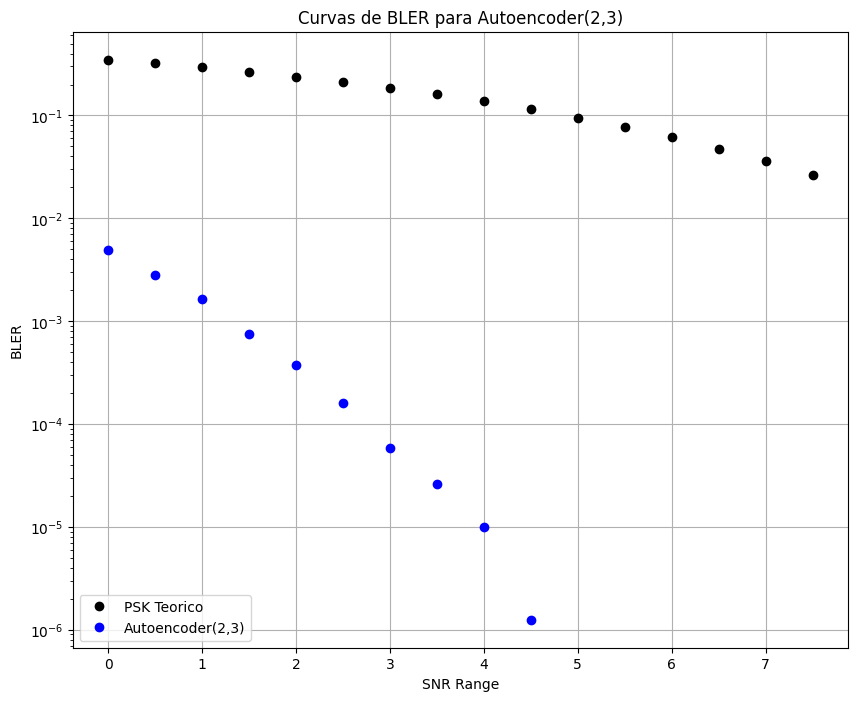

<Figure size 640x480 with 0 Axes>

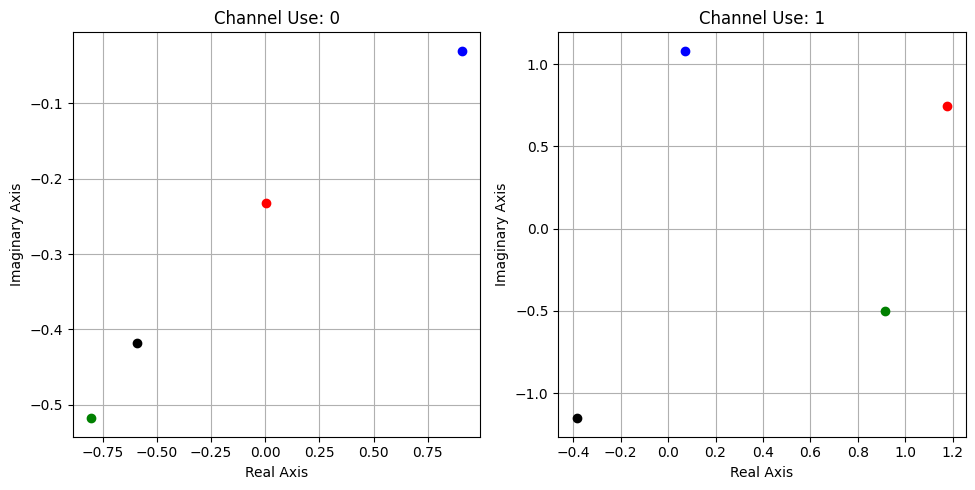

In [89]:
psk,loss_epoch_psk = pskTrain(2,3,1000)
lossCurve(loss_epoch_psk,2,3)
SERtest(psk,2,3,'psk')
vectorialSpace(psk,2,3)

## e) n = 2, k = 3 com modulação QAM

QAM - epoch [1/1000], loss:2.1012
QAM - epoch [2/1000], loss:2.0836
QAM - epoch [3/1000], loss:2.0829
QAM - epoch [4/1000], loss:2.0815
QAM - epoch [5/1000], loss:2.0840
QAM - epoch [6/1000], loss:2.0735
QAM - epoch [7/1000], loss:2.0494
QAM - epoch [8/1000], loss:2.0711
QAM - epoch [9/1000], loss:2.0503
QAM - epoch [10/1000], loss:2.0417
QAM - epoch [11/1000], loss:2.0487
QAM - epoch [12/1000], loss:2.0222
QAM - epoch [13/1000], loss:2.0281
QAM - epoch [14/1000], loss:2.0209
QAM - epoch [15/1000], loss:2.0179
QAM - epoch [16/1000], loss:2.0408
QAM - epoch [17/1000], loss:2.0094
QAM - epoch [18/1000], loss:1.9973
QAM - epoch [19/1000], loss:2.0017
QAM - epoch [20/1000], loss:2.0235
QAM - epoch [21/1000], loss:1.9909
QAM - epoch [22/1000], loss:1.9704
QAM - epoch [23/1000], loss:1.9739
QAM - epoch [24/1000], loss:1.9863
QAM - epoch [25/1000], loss:1.9719
QAM - epoch [26/1000], loss:1.9877
QAM - epoch [27/1000], loss:1.9341
QAM - epoch [28/1000], loss:1.9630
QAM - epoch [29/1000], loss:1

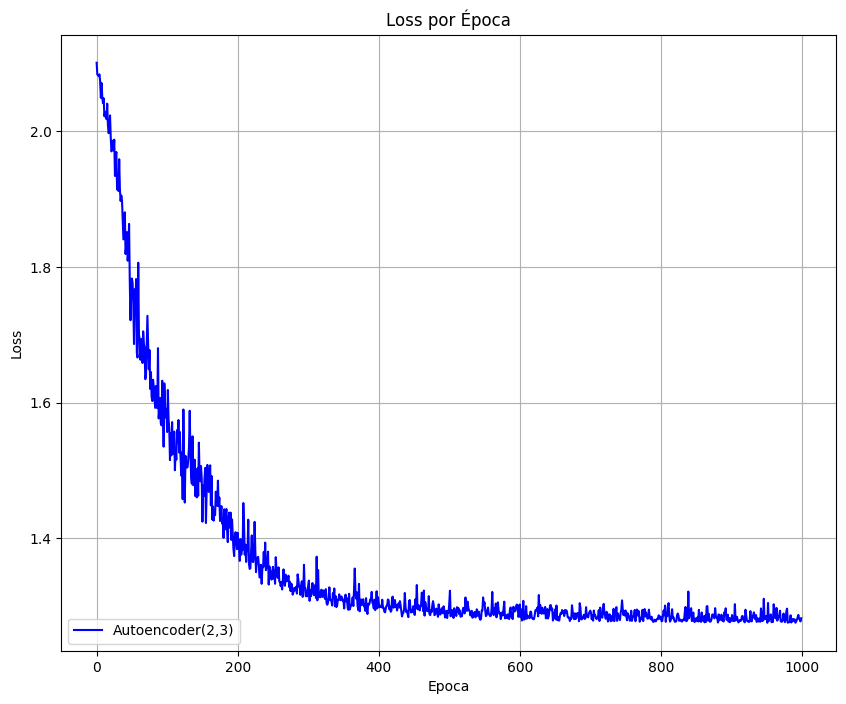

SNR: 0.0 BLER: 0.0045225 no_errors: 3618
SNR: 0.5 BLER: 0.0025425 no_errors: 2034
SNR: 1.0 BLER: 0.0013175 no_errors: 1054
SNR: 1.5 BLER: 0.00068 no_errors: 544
SNR: 2.0 BLER: 0.00027 no_errors: 216
SNR: 2.5 BLER: 0.00011 no_errors: 88
SNR: 3.0 BLER: 4.625e-05 no_errors: 37
SNR: 3.5 BLER: 2.125e-05 no_errors: 17
SNR: 4.0 BLER: 7.5e-06 no_errors: 6
SNR: 4.5 BLER: 2.5e-06 no_errors: 2
SNR: 5.0 BLER: 0.0 no_errors: 0
SNR: 5.5 BLER: 0.0 no_errors: 0
SNR: 6.0 BLER: 0.0 no_errors: 0
SNR: 6.5 BLER: 0.0 no_errors: 0
SNR: 7.0 BLER: 0.0 no_errors: 0
SNR: 7.5 BLER: 0.0 no_errors: 0


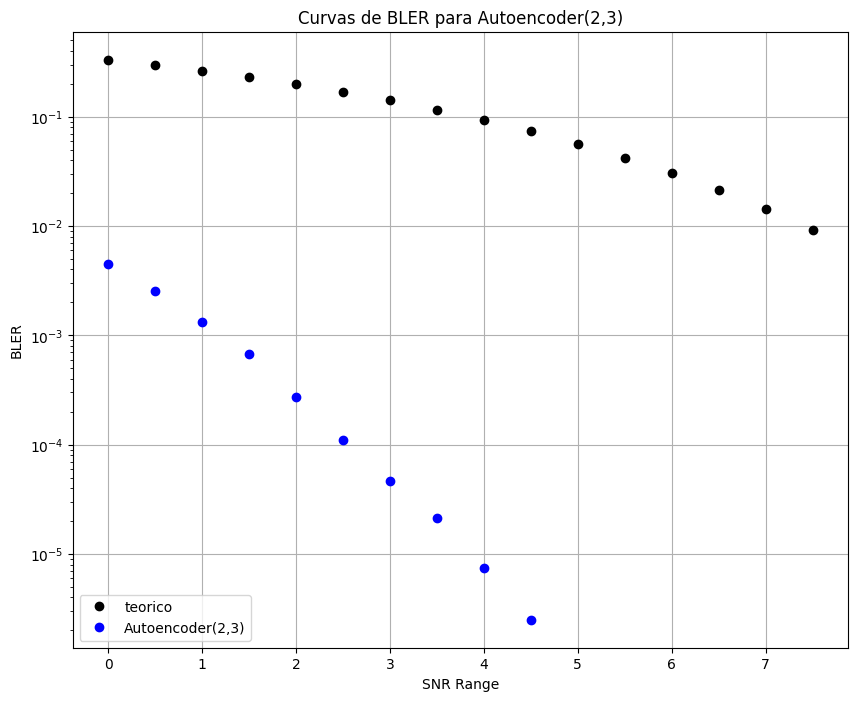

<Figure size 640x480 with 0 Axes>

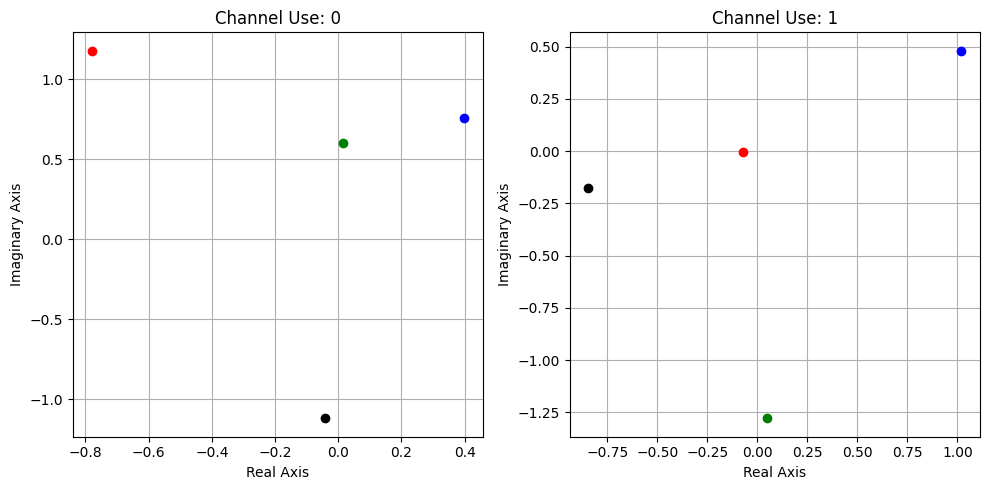

In [90]:
qam,loss_epoch_qam = qamTrain(2,3,1000)
lossCurve(loss_epoch_qam,2,3)
SERtest(qam,2,3,'qam')
vectorialSpace(qam,2,3)